# Breast Cancer

**Data Set Information:**

There are two classes (binary classification): “no-recurrence-events” and “recurrence-events”, that describe whether the patient’s cancer reappeared after treatment. The other 9 attributes contain general information about the patients themselves as well as more specific information about their individual cancer diagnoses. Using this information the goal is to classify whether a patient will have breast cancer again, or not


**Attribute Information:**

**- Class:** Describes if a patient had recurrent tumors;<br>
**- age:** Age listed in Interval of 10 years;<br>
**- menopause:** Nominal Short text description;<br>
**- tumor-size:** Interval in which falls the diamater of tumor falls;<br>
**- inv-nodes:** Interval in which falls the number of lymph-nodes in close proximity of the tumor;<br>
**- node-caps:** Nominal Describe whenever there're metastases or not;<br>
**- deg-malig:** Numerical Describe how bad the cancer is;<br>
**- breast:** Nominal Describe the afflicted breast;<br>
**- breast-quad:** Nominal Text representing the location of  tumor in the breast.<br>
**- irradiate** Nominal yes/no Indicates whenever the patient underwent radiation therapy.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the data

In [2]:
data = pd.read_csv('breast-cancer.csv')

*Remove quotation marks*

In [3]:
for column in data:
    data[column] = data[column].map(lambda x: x.lstrip("'").rstrip("'"))

In [4]:
data

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,50-59,ge40,30-34,6-8,yes,2,left,left_low,no,no-recurrence-events
282,50-59,premeno,25-29,3-5,yes,2,left,left_low,yes,no-recurrence-events
283,30-39,premeno,30-34,6-8,yes,2,right,right_up,no,no-recurrence-events
284,50-59,premeno,15-19,0-2,no,2,right,left_low,no,no-recurrence-events


# Basic Data Information

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    286 non-null    object
 5   deg-malig    286 non-null    object
 6   breast       286 non-null    object
 7   breast-quad  286 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: object(10)
memory usage: 11.2+ KB


In [6]:
data.describe()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
count,286,286,286,286,286,286,286,286,286,286
unique,6,3,11,7,3,3,2,6,2,2
top,50-59,premeno,30-34,0-2,no,2,left,left_low,no,no-recurrence-events
freq,96,150,60,213,222,130,152,110,218,201


# Check for missing values

In [7]:
data.replace("?", np.nan, inplace= True)
print(data.isnull().sum())

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
Class          0
dtype: int64


# Exploratory Data Analysis

*Countplot of the Target* 

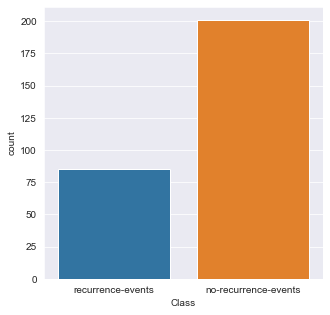

In [8]:
fig = plt.figure(figsize = (5,5))
sns.set_style('darkgrid')
sns.countplot(x = data['Class'])
plt.show()


**Class on Age Interval**

*Check Age Interval in the dataset*

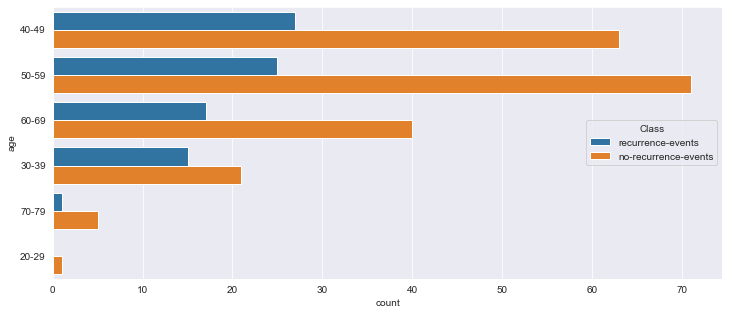

In [9]:
plt.figure(figsize=(12, 5))
sns.countplot(y="age", hue="Class", data=data)
plt.show()

**Class on Menopause**

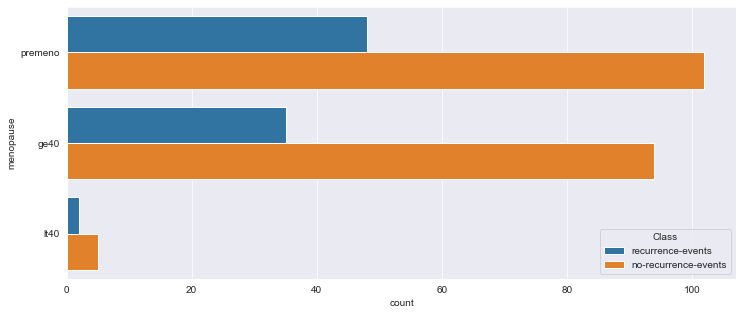

In [10]:
plt.figure(figsize=(12, 5))
sns.countplot(y="menopause", hue="Class", data=data)
plt.show()

**Class on Breast**

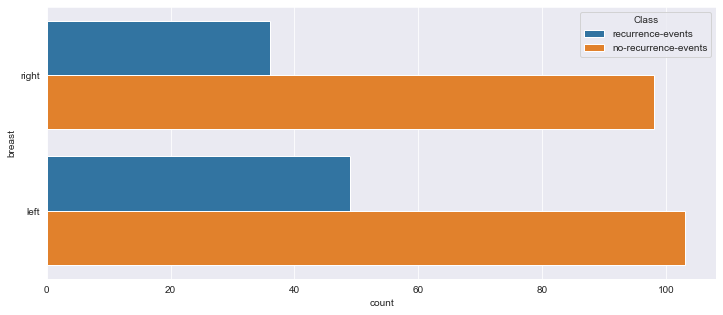

In [11]:
plt.figure(figsize=(12, 5))
sns.countplot(y="breast", hue="Class", data=data)
plt.show()

**Class on Breast-Quad**

*Divide par Left/Right breast*

In [12]:
right_b = data.loc[data['breast'] == 'right']
left_b = data.loc[data['breast'] == 'left']

[Text(0, 0.5, 'Right Breast')]

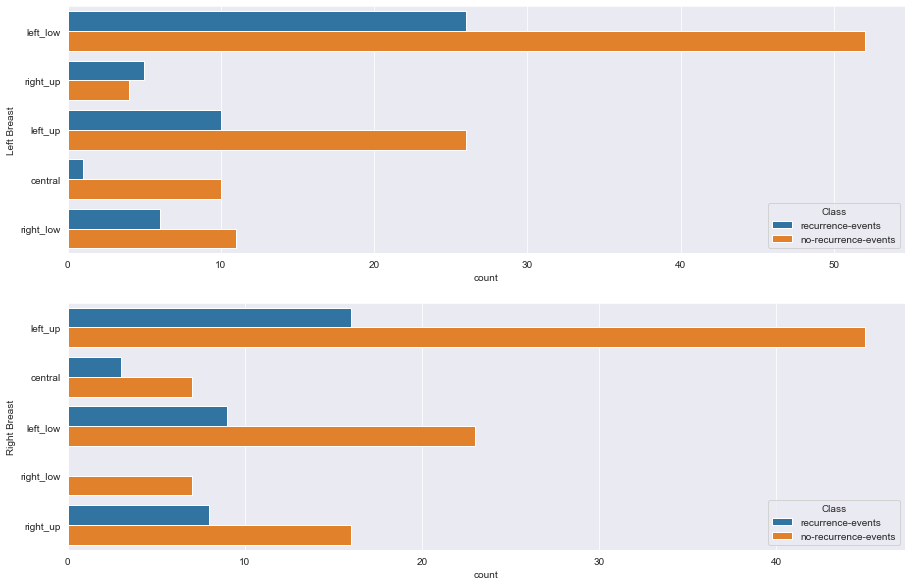

In [13]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=left_b['breast-quad'], hue="Class", data=data, ax = ax1)
ax1.set( ylabel='Left Breast')

ax2 = fig.add_subplot(2,1,2)
sns.countplot(y=right_b['breast-quad'], hue="Class", data=data, ax=ax2)
ax2.set(ylabel='Right Breast')

**Class on Degree of Malignancy**

TypeError: Neither the `x` nor `y` variable appears to be numeric.

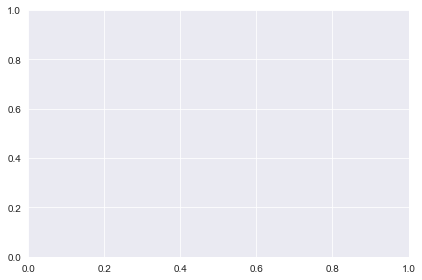

In [16]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,2,1)
deg_malig = data['deg-malig'].astype(float)
sns.violinplot(data = data, x='Class', y=deg_malig, ax=ax1)
sns.swarmplot(data = data, x='Class', y='deg-malig', color = 'k', alpha = 0.6, ax=ax1)


**Class on Lymph-Nodes**

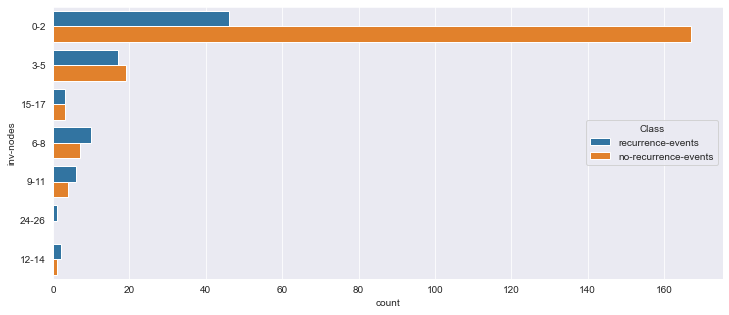

In [131]:
plt.figure(figsize=(12, 5))
sns.countplot(y="inv-nodes", hue="Class", data=data)
plt.show()

**Class on Metastases**

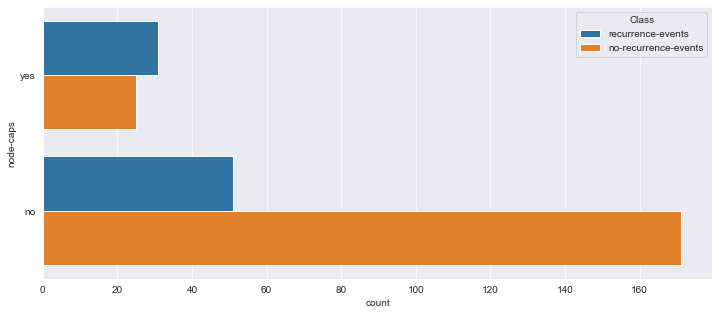

In [132]:
plt.figure(figsize=(12, 5))
sns.countplot(y="node-caps", hue="Class", data=data)
plt.show()

**Class on Irradiate**

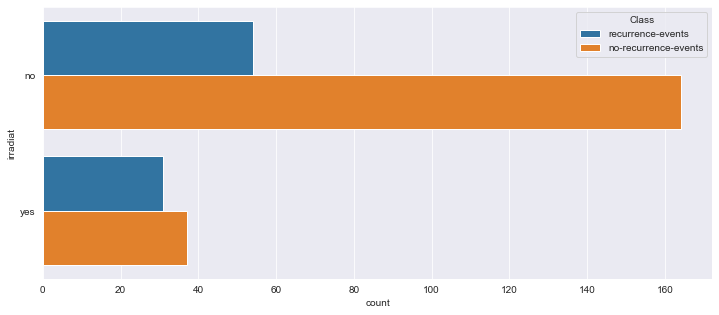

In [134]:
plt.figure(figsize=(12, 5))
sns.countplot(y="irradiat", hue="Class", data=data)
plt.show()